In [1]:
import mysql.connector

import pandas as pd
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns

# Link MySQL and Python
We want to connect MySQL and Python to read the database in Python directly. Using mysql connector seems appropriate here. Let's write a class that will load the database

In [2]:
class MysqlIO:
    def __init__(self, database='test'):
            connection = mysql.connector.connect(host='127.0.0.1', 
                                                 port='3306',
                                                 database=database,
                                                 user='root',
                                                 password='ForSQL!1',
                                                 use_pure=True
                                                 )
            db_info = connection.get_server_info()
            self.connection = connection
            print(f"Retrieval of database {database} Successful")
            
    def execute(self, query, header=False):
        """Execute SQL commands and return retrieved queries."""
        cursor = self.connection.cursor(buffered=True)
        cursor.execute(query)
        try:
            record = cursor.fetchall()
            if header:
                header = [i[0] for i in cursor.description]
                return {'header': header, 'record': record}
            else:    
                return record
        except:
            pass
        
    def to_df(self, query):
        """Return the retrieved SQL queries into pandas dataframe"""
        res = self.execute(query, header=True)
        df = pd.DataFrame(res['record'])
        df.columns = res['header']
        return df

In [3]:
db = MysqlIO('bank_1999')

Retrieval of database bank_1999 Successful


# Data Exploration

With so many tables, it can be overwhelming to know what to look for. But let's look at them one by one and see what comes up as interesting

### Loan and Account Table
Since the loan and account tables are directly related, we can look at these first

In [5]:
query = """
    select 
    loan_t.date as loan_date, account_t.date as account_date, 
    loan_id, account_id, amount, duration, payments, status, district_id, frequency
    from loan_t 
    join account_t 
    using(account_id);
    """
loan_account_df = db.to_df(query)
display(loan_account_df.head())

,loan_date,account_date,loan_id,account_id,amount,duration,payments,status,district_id,frequency
0,1993-11-22,1993-01-13,6077,5270,79608,24,3317.00,A,44,POPLATEK MESICNE
1,1993-09-15,1993-01-14,7284,11265,52788,12,4399.00,A,15,POPLATEK MESICNE
2,1993-11-10,1993-01-17,7121,10364,21924,36,609.00,A,55,POPLATEK MESICNE
3,1994-09-28,1993-01-19,5754,3834,23052,12,1921.00,A,54,POPLATEK MESICNE
4,1994-09-19,1993-01-24,6895,9307,41904,12,3492.00,A,68,POPLATEK MESICNE


In the column 'status', A and C are still in good standing, and B and D have likley defaulted. Let's make a new column to show this.

I also want to change the frequency column, to values that are easier to understand. 

And lastly, It would be good to know the time between the date the account was created and date the loan was created.

In [27]:
loan_account_df['defaulted'] = np.where(loan_account_df['status'].isin(['A', 'C']), 'no', 'yes')

# Replace Frequency Values
loan_account_df.replace({'POPLATEK MESICNE': 'monthly', 'POPLATEK TYDNE': 'weekly', 'POPLATEK PO OBRATU': 'instant'}, 
                        inplace=True)


# Date conversion
for col in ['loan_date', 'account_date']:
    loan_account_df[col] = pd.to_datetime(loan_account_df[col]) 

loan_account_df['time_elapsed'] = (loan_account_df['loan_date'] - loan_account_df['account_date']).dt.days

display(loan_account_df.sample(10))

,loan_date,account_date,loan_id,account_id,amount,duration,payments,status,district_id,frequency,defaulted,time_elapsed
203,1995-07-25,1994-11-15,6153,5632,285600,60,4760.00,C,5,weekly,no,252
371,1997-11-28,1996-03-15,5103,666,12540,12,1045.00,A,27,monthly,no,623
452,1998-05-24,1996-07-19,5699,3562,174960,24,7290.00,C,50,monthly,no,674
461,1997-08-31,1996-07-27,6612,7907,97392,12,8116.00,A,70,monthly,no,400
379,1998-01-20,1996-03-27,5569,2936,504000,60,8400.00,C,3,monthly,no,664
68,1994-08-03,1993-06-16,6836,9093,189300,60,3155.00,C,47,monthly,no,413
236,1995-09-22,1995-03-04,7008,9897,36168,12,3014.00,A,1,monthly,no,202
314,1997-04-26,1995-11-10,7253,11079,98304,12,8192.00,A,16,monthly,no,533
112,1995-01-14,1993-09-15,6358,6715,137880,60,2298.00,D,48,weekly,yes,486
17,1994-01-05,1993-02-26,4959,2,80952,24,3373.00,A,1,monthly,no,313


no     606
yes     76
Name: defaulted, dtype: int64
amount


<Figure size 504x360 with 0 Axes>

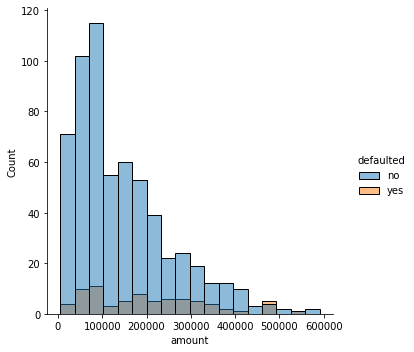

duration


<Figure size 504x360 with 0 Axes>

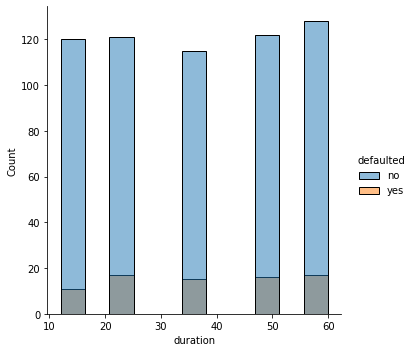

payments


<Figure size 504x360 with 0 Axes>

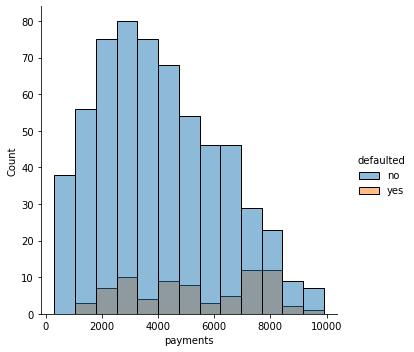

frequency


<Figure size 504x360 with 0 Axes>

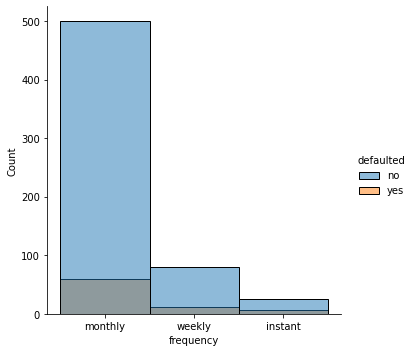

district_id


<Figure size 504x360 with 0 Axes>

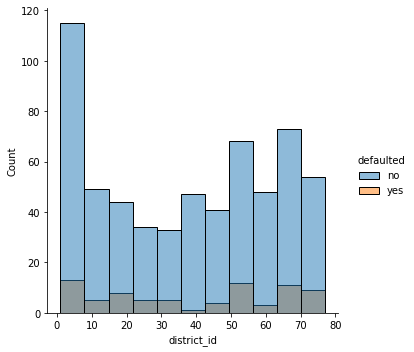

time_elapsed


<Figure size 504x360 with 0 Axes>

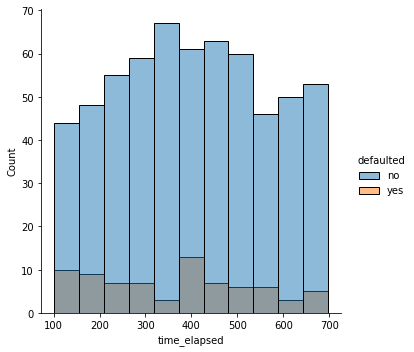

account_date


<Figure size 504x360 with 0 Axes>

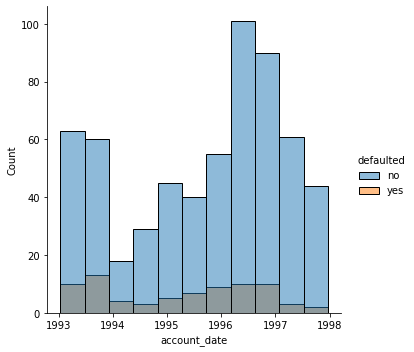

loan_date


<Figure size 504x360 with 0 Axes>

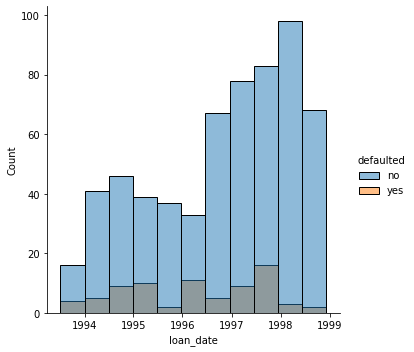

In [29]:
print(loan_account_df['defaulted'].value_counts())

for x in ['amount', 'duration', 'payments', 'frequency', 'district_id', 'time_elapsed', 'account_date', 'loan_date']:
    print(x)
    graph.figure(figsize=(7,5))
    sns.displot(data=loan_account_df, x =x, hue='defaulted')
    graph.show()

## INTERESTING COLUMNS HERE

### Loan, account, order
Since the loan and account tables are directly related, we can look at these first